In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import sys
from itertools import product
import pandas as pd

from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalHingeLoss, CategoricalCrossEntropyLoss
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics
from optimizers import SGDOptimizer
from lr_schedules import LRConstantSchedule, LRExponentialDecaySchedule, LRCyclingSchedule

In [2]:
# train set is batch 1, val set is batch 2, test set is test

path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

#np.testing.assert_array_equal(train_ratios, val_ratios)
#np.testing.assert_array_equal(val_ratios, test_ratios)

np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

train set shape: (10000, 32, 32, 3), val set shape: (10000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (10000,), val labels shape: (10000,), test labels shape: (10000,)


In [3]:
def plot_losses(history):
    plt.plot(history["loss_train"], label="train")
    plt.plot(history["loss_val"], label="val")
    plt.grid()
    plt.title("Loss vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    path = "losses.png"
    plt.savefig(path)
    plt.show()
    
def plot_costs(history):
    plt.plot(history["cost_train"], label="train")
    plt.plot(history["cost_val"], label="val")
    plt.grid()
    plt.title("Cost vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.legend()
    path = "costs.png"
    plt.savefig(path)
    plt.show()
    
def plot_accuracies(history):
    plt.plot(history["accuracy_train"], label="train")
    plt.plot(history["accuracy_val"], label="val")
    plt.grid()
    plt.title("Accuracy vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    path = "accuracies.png"
    plt.savefig(path)
    plt.show()
    
def plot_lr(history):
    plt.plot(history["lr"], label="lr")
    plt.grid()
    plt.title("Learning rate vs. epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Learning rate")
    plt.legend()
    path = "lrs.png"
    plt.savefig(path)
    plt.show()

model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: softmax


starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 71.75it/s]
epoch 1/10 
 	 -- train loss = 1.81727213477766 / train cost = 2.1124923400438544, train accuracy = 0.3614 
	 -- val loss = 1.8966084831123495 / val cost = 2.191828688378544, val accuracy = 0.3275 


starting epoch: 2 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 74.47it/s]
epoch 2/10 
 	 -- train loss = 1.6917767587007162 / train cost = 1.9748050744393644, train accuracy = 0.4111 
	 -- val loss = 1.8453916330535514 / val cost = 2.1284199487921995, val accuracy = 0.3608 


starting epoch: 3 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 75.92it/s

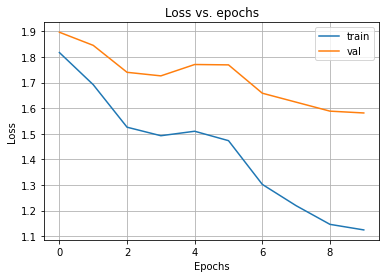

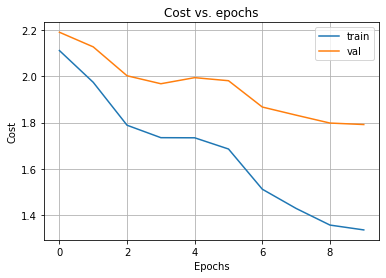

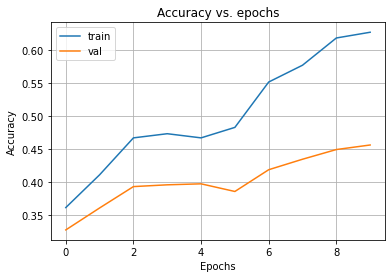

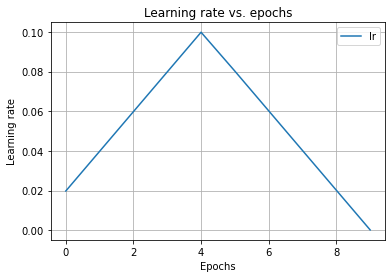

test acc: 0.4572


In [4]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
reg_rate_l2 = 0.01

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 10
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 500
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_costs(history)
plot_accuracies(history)
plot_lr(history)

scores_test = model.forward(x_test)
y_hat_test = np.argmax(scores_test, axis=1)
acc_test = AccuracyMetrics().get_metrics(y_test, y_hat_test)

print(f"test acc: {acc_test}")

model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: softmax


starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 78.23it/s]
epoch 1/50 
 	 -- train loss = 1.8779345372409295 / train cost = 2.606658945539659, train accuracy = 0.3417 
	 -- val loss = 1.93937876576476 / val cost = 2.6681031740634893, val accuracy = 0.3172 


starting epoch: 2 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 75.65it/s]
epoch 2/50 
 	 -- train loss = 1.6865258582677822 / train cost = 2.359775230345653, train accuracy = 0.411 
	 -- val loss = 1.8015764640320853 / val cost = 2.4748258361099564, val accuracy = 0.365 


starting epoch: 3 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 73.05it/s]
e

batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 87.37it/s]
epoch 28/50 
 	 -- train loss = 1.1762081238092188 / train cost = 1.4410945977345335, train accuracy = 0.5994 
	 -- val loss = 1.5676381237532249 / val cost = 1.8325245976785398, val accuracy = 0.4568 


starting epoch: 29 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 79.31it/s]
epoch 29/50 
 	 -- train loss = 1.15078135528435 / train cost = 1.4208250400977291, train accuracy = 0.6156 
	 -- val loss = 1.5626182796493369 / val cost = 1.832661964462716, val accuracy = 0.4542 


starting epoch: 30 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 77.01it/s]
epoch 30/50 
 	 -- train loss = 1.109012681719807 / train cost = 1.3839547828986614, train accuracy = 0.6396 
	 -- val loss = 1.5429413234709448 / val cost = 1.8178834246497992, val accuracy = 0.4636 


starting epoch: 31 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 79.59it/s]
epoch 31/50 
 	 -- train loss = 1.0877790690659295 / train cost

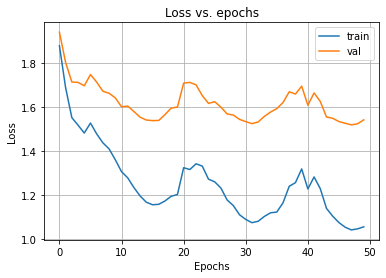

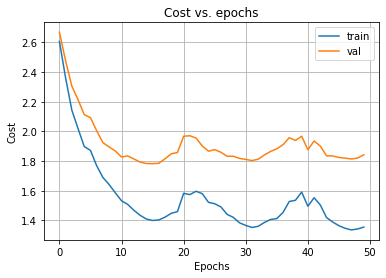

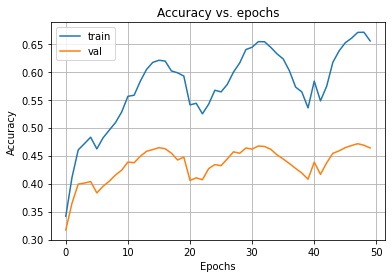

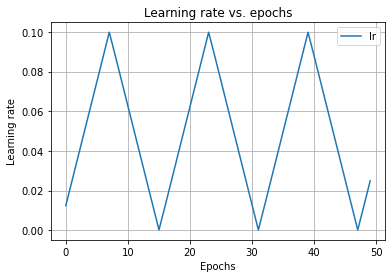

test acc: 0.4713


In [5]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
reg_rate_l2 = 0.025

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 50
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 800
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_costs(history)
plot_accuracies(history)
plot_lr(history)

scores_test = model.forward(x_test)
y_hat_test = np.argmax(scores_test, axis=1)
acc_test = AccuracyMetrics().get_metrics(y_test, y_hat_test)

print(f"test acc: {acc_test}")

In [6]:
class Tuner():
    def __init__(self, build_model, objective, iterations=1, **params):
        # objective is of Metrics for now
        self.build_model = build_model
        self.objective = objective
        self.iterations = iterations
        self.params = params
        self.params_product = list(product(*params.values()))
        self.params_names = list(params.keys())
    
    def search(self, x_train, y_train, x_val, y_val, n_epochs, batch_size):
        # list of tuples = list(product([1,2,3],[3,4]))
        # for tuple in list:
        # rows in final df
        rows = []
        
        #params_product = tqdm(self.params_product, file=sys.stdout)
        
        n_prod = len(self.params_product)
        
        for idx_prod, prod in enumerate(self.params_product):
            
            params = {}
            for idx, param_name in enumerate(self.params_names):
                params[param_name] = prod[idx]
            #print(params)
            #print(n_prod)
            
            # if more than 1 iterations
            objective_list = []
            
            for it in range(self.iterations):
                print("*"*5)
                print(f"tuner: {idx_prod+1}/{n_prod} config (iter: {it+1}/{self.iterations})")
                # build_model with tuple params
                model = build_model(seed=200, **params)
                # fit model
                history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)
                # meaasure objective on model
                scores_val = model.forward(x_val)
                y_hat_val = np.argmax(scores_val, axis=1)
                objective_val = self.objective.get_metrics(y_val, y_hat_val)
                # save objective in list
                objective_list.append(objective_val)
                
            # average objective in list
            objective_mean = np.array(objective_list).mean()
            # save tuple of params and objective as dict
            objective_dict = {self.objective.name: objective_mean}
            row_dict = {**params, **objective_dict}
            rows.append(row_dict)
            print("*"*5 + "\n")
            
        # df from list of dicts of params and objective val
        df = pd.DataFrame(data=rows)
        
        # save to csv
        date_string = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")
        path = os.path.join("tuner_results", date_string + ".csv")
        
        df.to_csv(path, encoding='utf-8', index=False)
        
        # argmax across rows and return best params as dict (~**params)
        best_params = dict(df.loc[df[self.objective.name].idxmax()])
        best_objective = best_params.pop(self.objective.name)
        
        return best_objective, best_params

In [21]:
def build_model_func(seed=200, **params):
    
    assert "reg_rate_l2" in params.keys()
    reg_rate_l2 = params["reg_rate_l2"]
    
    params = {"coeff": 1.0, "mean": 0.0, "std":None}

    #reg_rate_l2 = 0.025

    in_dim = x_train.shape[1]
    out_dim = 10
    mid_dim = 50

    #seed = 200

    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim, 
              kernel_initializer=XavierInitializer(seed=seed, **params), 
              bias_initializer=XavierInitializer(seed=seed+1, **params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=ReLUActivation()
             )

    dense_2 = \
        Dense(in_dim=mid_dim, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed+2, **params), 
              bias_initializer=XavierInitializer(seed=seed+3, **params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=SoftmaxActivation()
             )

    layers = [
        dense_1,
        dense_2
    ]

    model = Model(layers)
    print(model)

    loss = CategoricalCrossEntropyLoss()

    # assignment:
    #n_epochs = 4
    #batch_size = 100

    lr_initial = 1e-5
    lr_max = 1e-1
    step_size = 900
    lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
    optimizer = SGDOptimizer(lr_schedule=lr_schedule)

    metrics = [AccuracyMetrics()]

    model.compile_model(optimizer, loss, metrics)
    #history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)
    
    return model

In [8]:
# Load data
# train set is batch 1, val set is batch 2, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img_1, y_train_1 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_train_img_2, y_train_2 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_3")
x_train_img_3, y_train_3 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_4")
x_train_img_4, y_train_4 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_5")
x_train_img_5, y_train_5 = load_cfar10_batch(path)

x_train_val_img = np.vstack([x_train_img_1, x_train_img_2, x_train_img_3, x_train_img_4, x_train_img_5])
y_train_val = np.hstack([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5])

x_train_img, x_val_img, y_train, y_val = train_test_split(x_train_val_img, y_train_val,
                                                          test_size=0.1, random_state=42)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# np.testing.assert_array_equal(train_ratios, val_ratios)
# np.testing.assert_array_equal(val_ratios, test_ratios)

#np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
#np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

# Pre-process data
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

train set shape: (45000, 32, 32, 3), val set shape: (5000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (45000,), val labels shape: (5000,), test labels shape: (10000,)


In [14]:
batch_size = 100

n_s = int(2*np.floor(x_train.shape[0] / batch_size))
print(f"step size of cyc. lr: {n_s} update steps")

cycle_steps = 2*n_s
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

#print(cycle * batch_size)

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 2
print(f"{n_cycle} cycle = {n_cycle*epochs} epochs = {n_cycle*cycle_steps} update steps")

step size of cyc. lr: 900 update steps
full cycle of cyc.lr : 1800 update steps
4.0 epochs = 1 full cycle = 1800 update steps
2 cycle = 8.0 epochs = 3600 update steps


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: softmax


starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 77.55it/s]
epoch 1/8 
 	 -- train loss = 1.6360532249887936 / train cost = 2.0981094489946717, train accuracy = 0.41884444444444446 
	 -- val loss = 1.6729948580595744 / val cost = 2.135051082065452, val accuracy = 0.4048 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 76.51it/s]
epoch 2/8 
 	 -- train loss = 1.6464774939676652 / train cost = 1.8367577691077885, train accuracy = 0.40344444444444444 
	 -- val loss = 1.7014059953687204 / val cost = 1.8916862705088437, val accuracy = 0.3854 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/4

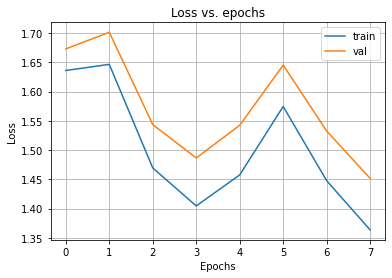

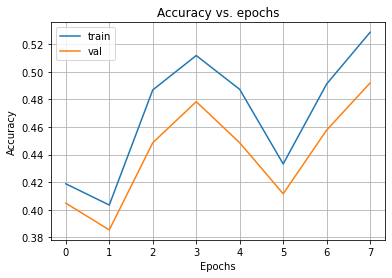

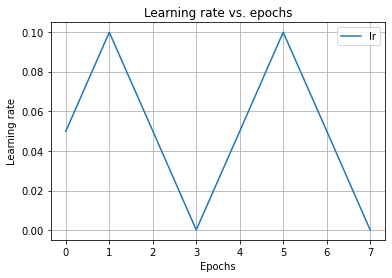

In [15]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
reg_rate_l2 = 0.025

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 8
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 900
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_accuracies(history)
plot_lr(history)

In [22]:
def coarse_custom(n):
    l_min = -5
    l_max = -1
    #np.random.seed(seed)
    
    return [10 **(l_min + (l_max - l_min) * np.random.uniform(low=0, high=1)) for i in range(n)]

def coarse_to_fine_custom(best_via_coarse, n):
    half_interval = 0.2
    low = best_via_coarse * (1-half_interval) 
    high = best_via_coarse * (1+half_interval)
    
    return [np.random.uniform(low=low, high=high) for i in range(n)] 

In [23]:
objective = AccuracyMetrics()
build_model = build_model_func

# coarse
n = 10
n_epochs = 8
batch_size = 100

params = {"reg_rate_l2": coarse_custom(n=n)}
tuner = Tuner(build_model, objective, iterations=1, **params)
best_objective, best_params = tuner.search(x_train, y_train, x_val, y_val, n_epochs, batch_size)

print(f"best obj:{best_objective:.4f}, with {best_params}")

# coarse to fine
n = 10
n_epochs = 8
batch_size = 100

params = {"reg_rate_l2": coarse_to_fine_custom(best_params["reg_rate_l2"], n=n)}
tuner = Tuner(build_model, objective, iterations=1, **params)
best_objective, best_params = tuner.search(x_train, y_train, x_val, y_val, n_epochs, batch_size)

print(f"best obj:{best_objective:.4f}, with {best_params}")

*****
tuner: 1/10 config (iter: 1/1)
model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: softmax


starting epoch: 1 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 76.11it/s]
epoch 1/8 
 	 -- train loss = 1.6579650225242581 / train cost = 1.6709531981958887, train accuracy = 0.41575555555555554 
	 -- val loss = 1.7077257506941257 / val cost = 1.7207139263657563, val accuracy = 0.3958 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:06<00:00, 74.97it/s]
epoch 2/8 
 	 -- train loss = 1.6325684377121827 / train cost = 1.6466365367120075, train accuracy = 0.4142222222222222 
	 -- val loss = 1.7336697559139709 / val cost = 1.7477378549137956, val accuracy = 0.3944 


starting epoch: 3 ...


batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 88.12it/s]
epoch 1/8 
 	 -- train loss = 1.651712538225544 / train cost = 1.6797676958341403, train accuracy = 0.4189555555555556 
	 -- val loss = 1.7032279362648863 / val cost = 1.7312830938734827, val accuracy = 0.4006 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 88.95it/s]
epoch 2/8 
 	 -- train loss = 1.614539319276042 / train cost = 1.6441562229878004, train accuracy = 0.42388888888888887 
	 -- val loss = 1.7074061709728252 / val cost = 1.7370230746845836, val accuracy = 0.4066 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 88.34it/s]
epoch 3/8 
 	 -- train loss = 1.3722280127212947 / train cost = 1.4043501493003445, train accuracy = 0.5182 
	 -- val loss = 1.5099689942143333 / val cost = 1.5420911307933831, val accuracy = 0.4648 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 89.34it/s]
epoch 4/8 
 	 -- train loss = 1.2895393788229

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 89.57it/s]
epoch 1/8 
 	 -- train loss = 1.639132881518726 / train cost = 1.8459681159432746, train accuracy = 0.42013333333333336 
	 -- val loss = 1.6880231544692272 / val cost = 1.8948583888937758, val accuracy = 0.4018 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 86.88it/s]
epoch 2/8 
 	 -- train loss = 1.6121986608099654 / train cost = 1.7672617411932683, train accuracy = 0.41931111111111113 
	 -- val loss = 1.6928133663220262 / val cost = 1.847876446705329, val accuracy = 0.4024 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 89.35it/s]
epoch 3/8 
 	 -- train loss = 1.3977791672478237 / train cost = 1.5312942428145035, train accuracy = 0.5107111111111111 
	 -- val loss = 1.5112737180077966 / val cost = 1.6447887935744765, val accuracy = 0.4662 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 87.74it/s]
epoch 4/8 
 	 -- train loss = 1.

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 87.32it/s]
epoch 1/8 
 	 -- train loss = 1.6720328107508364 / train cost = 2.216500117475091, train accuracy = 0.40524444444444446 
	 -- val loss = 1.697626977714356 / val cost = 2.2420942844386103, val accuracy = 0.4012 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 86.87it/s]
epoch 2/8 
 	 -- train loss = 1.7267130425864847 / train cost = 1.9089064708836776, train accuracy = 0.3758222222222222 
	 -- val loss = 1.75818193206498 / val cost = 1.940375360362173, val accuracy = 0.3642 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 88.03it/s]
epoch 3/8 
 	 -- train loss = 1.5995891999468137 / train cost = 1.7869597915714843, train accuracy = 0.44037777777777776 
	 -- val loss = 1.6381395958524132 / val cost = 1.8255101874770838, val accuracy = 0.419 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 87.85it/s]
epoch 4/8 
 	 -- train loss = 1.5573

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 86.58it/s]
epoch 1/8 
 	 -- train loss = 1.6456561561711773 / train cost = 1.6567914754431194, train accuracy = 0.4184222222222222 
	 -- val loss = 1.6966142840800669 / val cost = 1.707749603352009, val accuracy = 0.4022 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 87.54it/s]
epoch 2/8 
 	 -- train loss = 1.6179627108274994 / train cost = 1.6300731075160908, train accuracy = 0.4177777777777778 
	 -- val loss = 1.7149448854967886 / val cost = 1.72705528218538, val accuracy = 0.3968 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 87.94it/s]
epoch 3/8 
 	 -- train loss = 1.3657610857791036 / train cost = 1.3792715476710395, train accuracy = 0.5224666666666666 
	 -- val loss = 1.504750170414743 / val cost = 1.518260632306679, val accuracy = 0.467 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 88.69it/s]
epoch 4/8 
 	 -- train loss = 1.282206

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 85.32it/s]
epoch 1/8 
 	 -- train loss = 1.6456566798858396 / train cost = 1.6567652747635546, train accuracy = 0.4184222222222222 
	 -- val loss = 1.696615432030723 / val cost = 1.707724026908438, val accuracy = 0.4022 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 79.35it/s]
epoch 2/8 
 	 -- train loss = 1.617783868600791 / train cost = 1.6298643469797214, train accuracy = 0.42031111111111114 
	 -- val loss = 1.7144782894141812 / val cost = 1.7265587677931116, val accuracy = 0.4012 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:06<00:00, 74.86it/s]
epoch 3/8 
 	 -- train loss = 1.3639486491992914 / train cost = 1.3774323407023632, train accuracy = 0.5224666666666666 
	 -- val loss = 1.507336750359413 / val cost = 1.5208204418624849, val accuracy = 0.4676 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 77.38it/s]
epoch 4/8 
 	 -- train loss = 1.281

batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 79.51it/s]
epoch 1/8 
 	 -- train loss = 1.6470917995887786 / train cost = 1.659669886594883, train accuracy = 0.4182888888888889 
	 -- val loss = 1.6966345467006592 / val cost = 1.7092126337067635, val accuracy = 0.4004 


starting epoch: 2 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 80.67it/s]
epoch 2/8 
 	 -- train loss = 1.6446673459494814 / train cost = 1.6583170063776016, train accuracy = 0.41413333333333335 
	 -- val loss = 1.7369886010702233 / val cost = 1.7506382614983436, val accuracy = 0.3926 


starting epoch: 3 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 78.60it/s]
epoch 3/8 
 	 -- train loss = 1.3693355153803404 / train cost = 1.3845052142133722, train accuracy = 0.5202222222222223 
	 -- val loss = 1.5138583172839148 / val cost = 1.5290280161169467, val accuracy = 0.4648 


starting epoch: 4 ...
batch 450/450: 100%|██████████| 450/450 [00:05<00:00, 80.95it/s]
epoch 4/8 
 	 -- train loss = 1.

## best model

In [26]:
# Load data
# train set is batch 1, val set is batch 2, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img_1, y_train_1 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_train_img_2, y_train_2 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_3")
x_train_img_3, y_train_3 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_4")
x_train_img_4, y_train_4 = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_5")
x_train_img_5, y_train_5 = load_cfar10_batch(path)

x_train_val_img = np.vstack([x_train_img_1, x_train_img_2, x_train_img_3, x_train_img_4, x_train_img_5])
y_train_val = np.hstack([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5])

x_train_img, x_val_img, y_train, y_val = train_test_split(x_train_val_img, y_train_val,
                                                          test_size=0.02, random_state=42)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# np.testing.assert_array_equal(train_ratios, val_ratios)
# np.testing.assert_array_equal(val_ratios, test_ratios)

#np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
#np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

# Pre-process data
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

train set shape: (49000, 32, 32, 3), val set shape: (1000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (49000,), val labels shape: (1000,), test labels shape: (10000,)


In [28]:
batch_size = 100

n_s = int(2*np.floor(x_train.shape[0] / batch_size))
print(f"step size of cyc. lr: {n_s} update steps")

cycle_steps = 2*n_s
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

#print(cycle * batch_size)

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 3
print(f"{n_cycle} cycle = {n_cycle*epochs} epochs = {n_cycle*cycle_steps} update steps")

step size of cyc. lr: 980 update steps
full cycle of cyc.lr : 1960 update steps
4.0 epochs = 1 full cycle = 1960 update steps
3 cycle = 12.0 epochs = 5880 update steps


model summary: 
layer 0: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 w -- init:Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: softmax


starting epoch: 1 ...
batch 490/490: 100%|██████████| 490/490 [00:06<00:00, 73.63it/s]
epoch 1/12 
 	 -- train loss = 1.624935388843581 / train cost = 1.6361015213847547, train accuracy = 0.4362857142857143 
	 -- val loss = 1.6432092214245262 / val cost = 1.6543753539657, val accuracy = 0.422 


starting epoch: 2 ...
batch 490/490: 100%|██████████| 490/490 [00:06<00:00, 77.73it/s]
epoch 2/12 
 	 -- train loss = 1.5339607006521971 / train cost = 1.5462230668813897, train accuracy = 0.45483673469387753 
	 -- val loss = 1.5770099784280118 / val cost = 1.5892723446572043, val accuracy = 0.459 


starting epoch: 3 ...
batch 490/490: 100%|██████████| 490/490 [

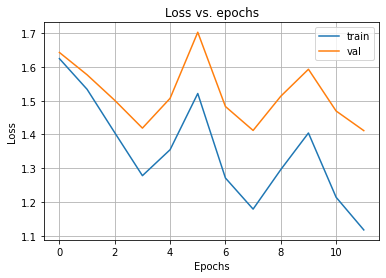

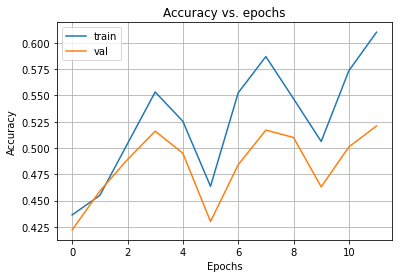

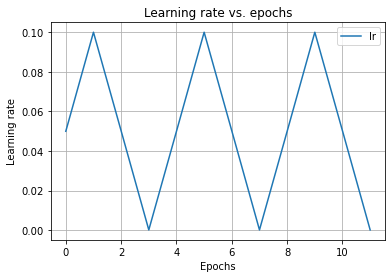

test acc: 0.517


In [30]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

#reg_rate_l2 = 0.1
# best obj:0.5134, with {'reg_rate_l2': 0.00036537637001811185}
reg_rate_l2 = best_params["reg_rate_l2"]
#print(reg_rate_l2)
#raise

in_dim = x_train.shape[1]
out_dim = 10
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)
print(model)

loss = CategoricalCrossEntropyLoss()

n_epochs = 12
batch_size = 100

#lr_initial = 0.01
#lr_schedule = LRConstantSchedule(lr_initial)
#decay_steps = n_epochs * 2
#decay_rate = 0.9
#lr_schedule = LRExponentialDecaySchedule(lr_initial, decay_steps, decay_rate)

lr_initial = 1e-5
lr_max = 1e-1
step_size = 980
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule)

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size)

plot_losses(history)
plot_accuracies(history)
plot_lr(history)

scores_test = model.forward(x_test)
y_hat_test = np.argmax(scores_test, axis=1)
acc_test = AccuracyMetrics().get_metrics(y_test, y_hat_test)

print(f"test acc: {acc_test}")